# SAE Feature ID

## Imports

In [1]:
import os
import json
import pathlib
import numpy as np
import pandas as pd
from sparsify import Sae

In [2]:
from data_tools.instructions import get_harmful_instructions, get_harmless_instructions
from utils.templates import PYTHIA_TEMPLATE
from utils.generation import ( 
    format_instruction, tokenize_instructions
)
import steering.linear_probing as lp_steer
import refusal.linear_probing as lp_refuse

from refusal.sae.sparsify.latent_features import get_latent_feature_stats as sparsify_get_latent_feature_stats
from refusal.sae.sparsify import utils as sparsify_utils

from evaluation.refusal import (
    get_refusal_scores, get_wildguard_refusal_score
)
from evaluation.sae_eval import compute_sae_stats

## Helper

In [3]:
# ensure everything is json-serialisable
def _to_jsonable(obj):
    if isinstance(obj, np.ndarray):          # arrays → list
        return obj.tolist()
    if isinstance(obj, (np.floating, np.integer)):
        return obj.item()
    if isinstance(obj, dict):
        return {k: _to_jsonable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple, set)):
        return [_to_jsonable(v) for v in obj]
    return obj     

In [4]:
def convert_dfs_to_json_serializable(obj):
    """
    Recursively traverses a dictionary or list and converts any
    pandas DataFrame into a JSON serializable format (list of records).

    Args:
        obj: The dictionary, list, or other object to process.

    Returns:
        A new object of the same type with DataFrames converted.
    """
    # If the object is a pandas DataFrame, convert it to a list of dictionaries
    if isinstance(obj, pd.DataFrame):
        return obj.to_dict('records')

    # If the object is a dictionary, recursively process its values
    if isinstance(obj, dict):
        return {key: convert_dfs_to_json_serializable(value) for key, value in obj.items()}

    # If the object is a list, recursively process its items
    if isinstance(obj, list):
        return [convert_dfs_to_json_serializable(item) for item in obj]

    # If it's none of the above, return the object as is (it's likely already serializable)
    return obj

## Settings

In [5]:
harmless_inst_train, harmless_inst_test = get_harmless_instructions()
harmful_inst_train, harmful_inst_test = get_harmful_instructions()

In [6]:
SAES = [
    {
        "name": "INS", 
        "path": "",
        "exp_factor": 16,
        "max_length": 64,
        "is_local": True
    },{
        "name": "PRE", 
        "path": "EleutherAI/sae-SmolLM2-135M-64x",
        "exp_factor": 64,
        "max_length": 1024,
        "is_local": False
    },{
        "name": "MIX_PRE",
        "path": "",
        "exp_factor": 16, 
        "max_length": 64,
        "is_local": True
    },{
        "name": "MIX_INS", 
        "path": "",
        "exp_factor": 16, 
        "is_local": True
    },{
        "name": "MIX_EQ", 
        "path": "",
        "exp_factor": 16, 
        "max_length": 64,
        "is_local": True
    }
]
LOCAL_LAYERS = [6, 25]
HUB_LAYERS = list(range(0,30,3))
N_INST_TRAIN = 100
MODEL_NAME = "HuggingFaceTB/SmolLM2-135M"

**Prepping dataset for Feature ID**

In [7]:
dataset = (
    [{"prompt": p, "label": 0} for p in harmless_inst_train[:N_INST_TRAIN]] +
    [{"prompt": p, "label": 1} for p in harmful_inst_train[:N_INST_TRAIN]]
)

## Feature ID

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Extracting representations:   0%|          | 0/200 [00:00<?, ?it/s]/home/tilman.kerl/miniconda3/envs/refusal/lib/python3.11/site-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(

100%|██████████| 10/10 [00:51<00:00,  5.16s/it]


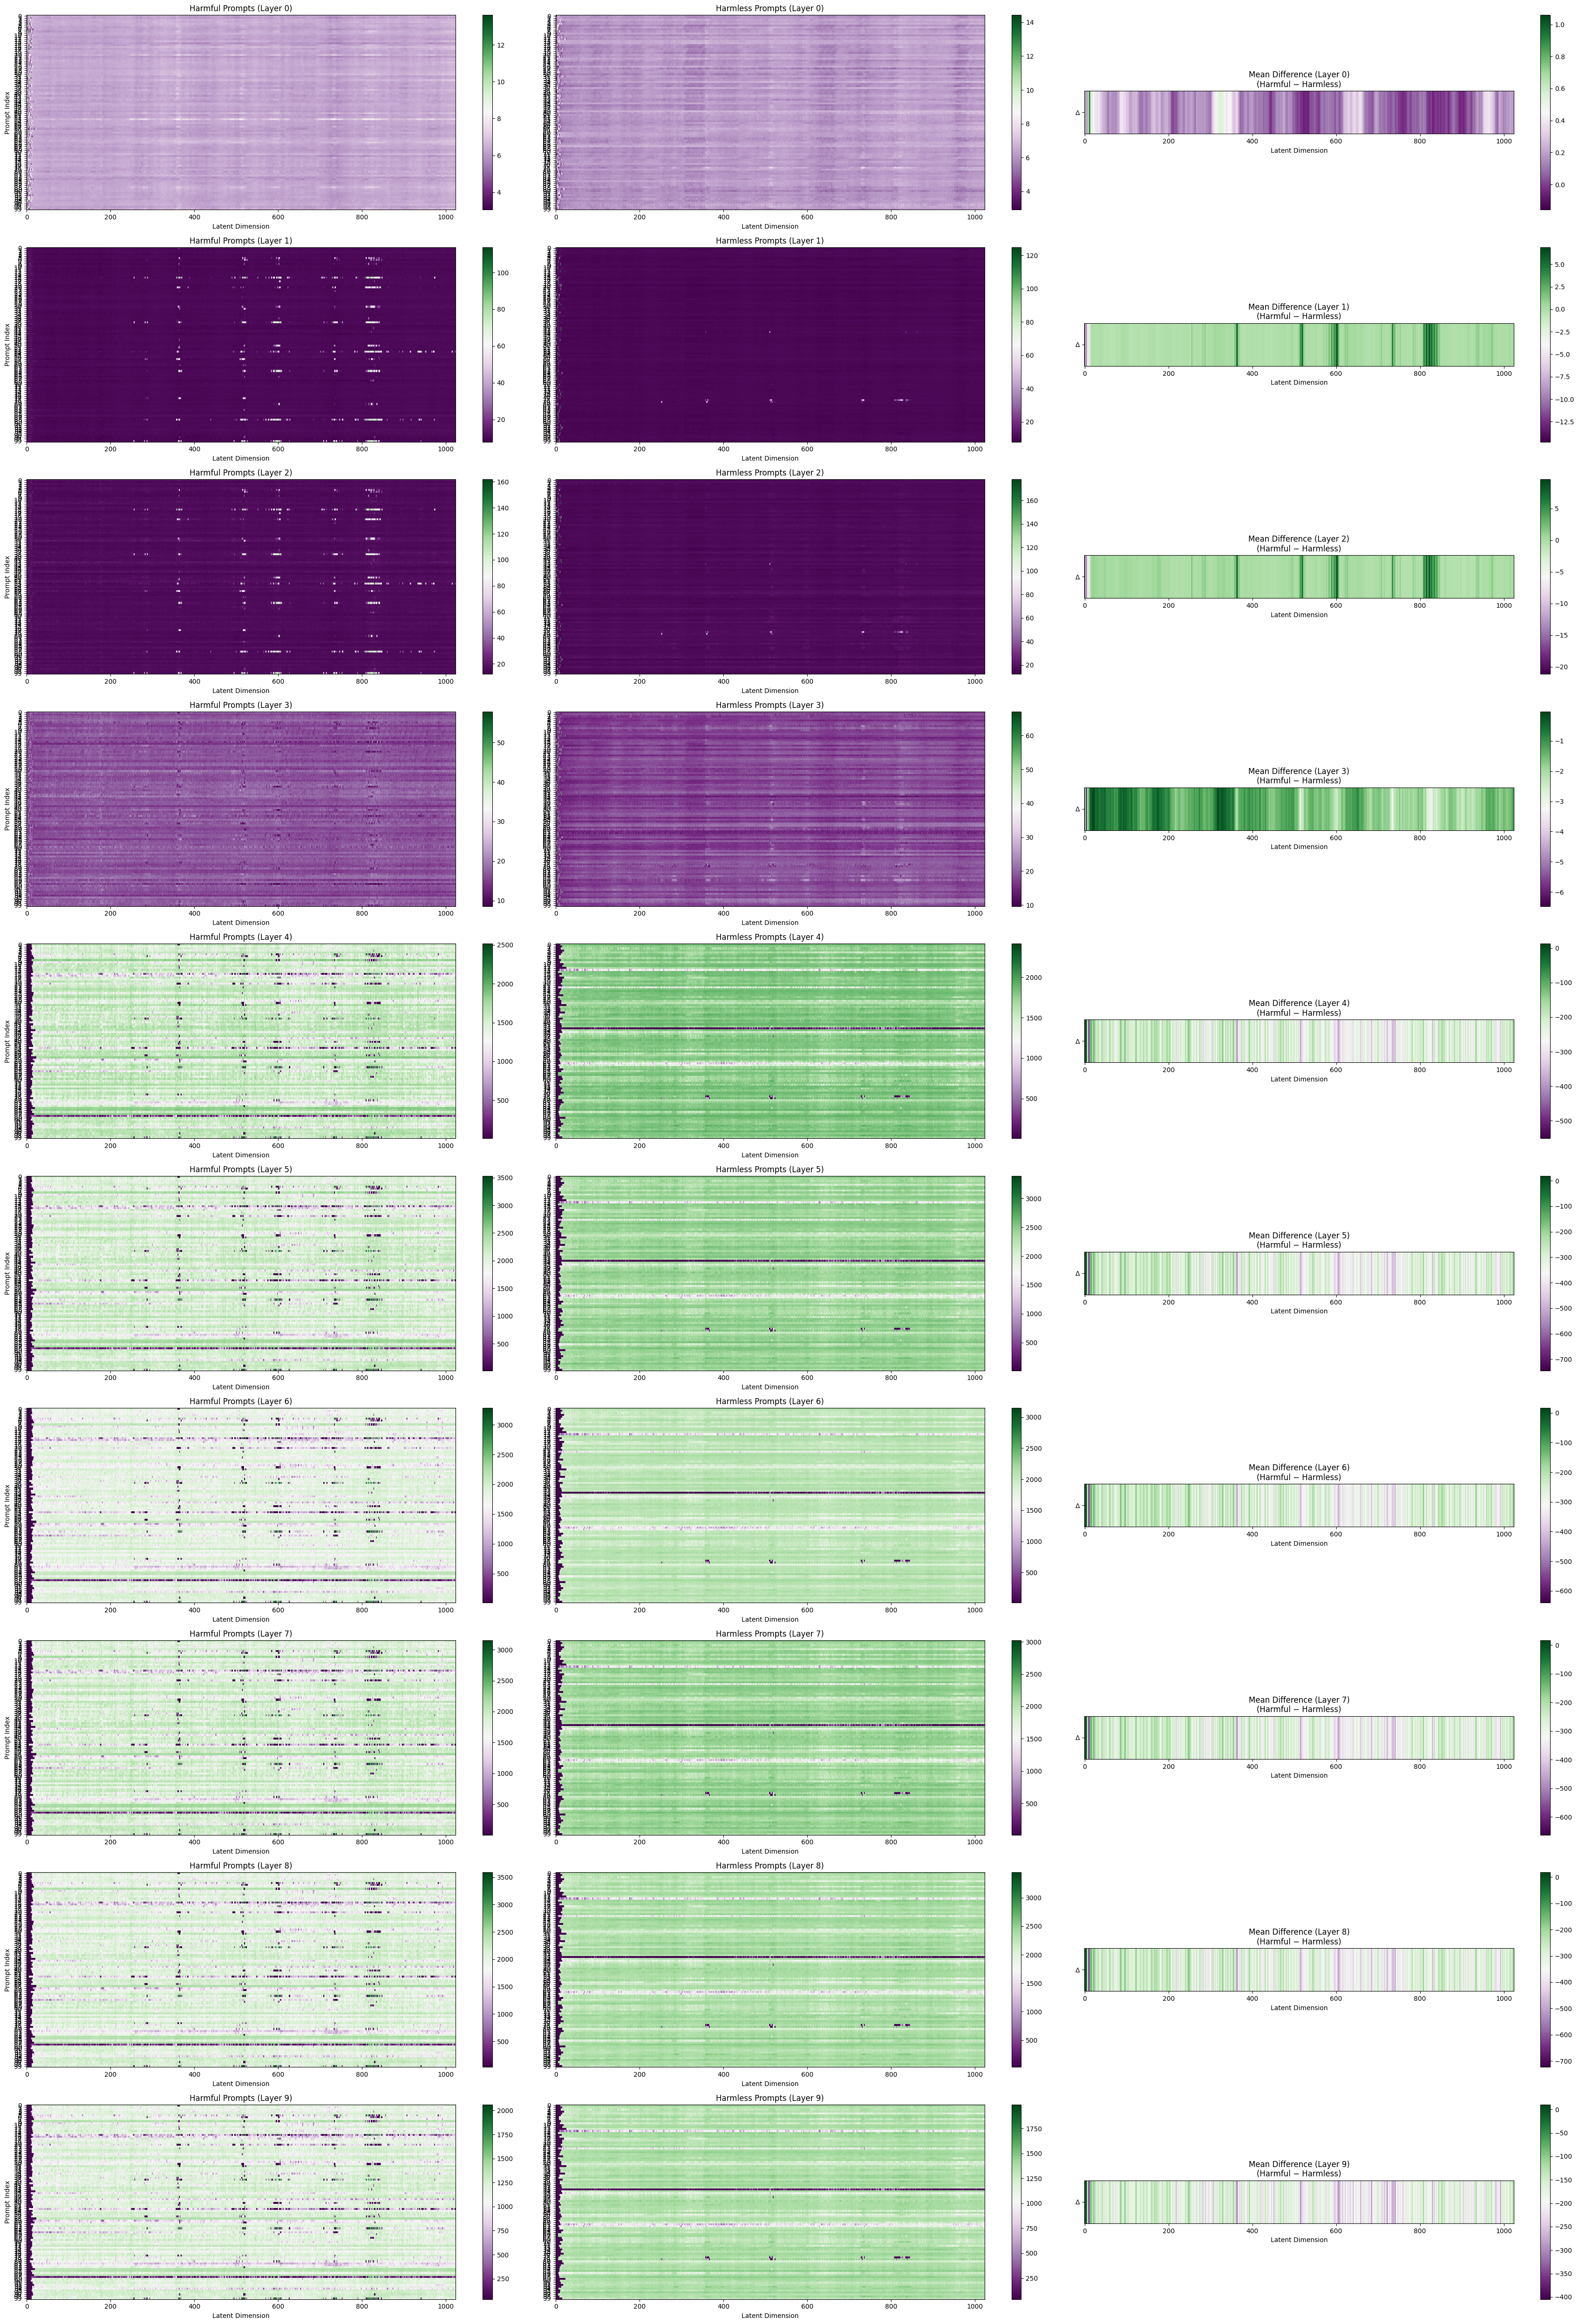

Top features overall (harmful):


layer  latent_dim  Cohen's d
0      0          25   2.039294
1      0         322   1.955879
2      0         321   1.949274
3      0         323   1.936082
4      0          26   1.919456

Top features overall (harmless):


layer  latent_dim  Cohen's d
0      9         901  -1.762142
1      9         902  -1.737755
2      9         926  -1.670915
3      9         903  -1.639367
4      9         927  -1.635780

In [8]:
for sae in SAES:
    if not sae["path"]: 
        continue
    
    sae_name = sae["path"].split("/")[-1]
    
    layers = LOCAL_LAYERS if sae["is_local"] else HUB_LAYERS
    results, harmful_reps_list, harmless_reps_list, diff_list = compute_sae_stats(
        sae["path"],
        MODEL_NAME, 
        layers, 
        dataset = dataset,
        exp_factor = sae["exp_factor"],
        max_length = sae["max_length"],
        is_local = sae["is_local"],
    )

    feature_summary = sparsify_utils.identify_top_features(
        results.copy(),
        layers=layers, 
        N=5
    )

    # visualize all layers in one figure
    sparsify_utils.visualize_latent_differences(
        harmful_reps_list, harmless_reps_list, diff_list,
        sae_name
    )

    print("Top features overall (harmful):")
    display(feature_summary["top_harmful"])
    print("Top features overall (harmless):")
    display(feature_summary["top_harmless"])
    
    payload = {
        "results": _to_jsonable(convert_dfs_to_json_serializable(results)),
        "summary": _to_jsonable(convert_dfs_to_json_serializable(feature_summary)),
    }

    # construct ./results/saes/features/{SAE_path}.json    
    out_dir = pathlib.Path("./results/saes/features")
    out_dir.mkdir(parents=True, exist_ok=True)
    outfile = out_dir / f"{sae_name}.json"

    with outfile.open("w") as fp:
        json.dump(payload, fp, indent=2)
    